In [7]:
import os
import re
import time
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import random
import pybullet as p
import pybullet_data
import trimesh
from collections import defaultdict, Counter
from utils.graph_env import set_objects
set_objects('set1')

from utils.graph_env import (
    OBJECTS,
    create_graph, plot_graph, cal_density,
    Indices, get_obj_label, get_obj_pos, get_obj_size,
    get_object_bellow,
)

def numeric_key(fn):
    # find the first run of digits in the filename
    m = re.search(r'(\d+)', fn)
    return int(m.group(1)) if m else float('inf')


# Create Object Files

In [ ]:
from utils.utils import create_obj
import shutil

def clear_files():
    for object_name in os.listdir("objects"):
        if object_name in ['sphere']:
            continue

        object_path = os.path.join("objects", object_name)
        for object_id in os.listdir(object_path):
            object_id_path = os.path.join(object_path, object_id)

            for f_name in os.listdir(object_id_path):
                f_path = os.path.join(object_id_path, f_name)

                # Remove 'assets' directory if it exists
                if f_name == "assets" and os.path.isdir(f_path):
                    try:
                        shutil.rmtree(f_path)
                        print(f"Removed directory: {f_path}")
                    except Exception as e:
                        print(f"Error removing directory {f_path}: {e}")
                    continue  # Skip further checks for this item

                # Check if it is a file (not a directory)
                if os.path.isfile(f_path):
                    # Keep only files ending with .glb or .blend
                    if not (f_name.endswith('.glb') or f_name.endswith('.blend')):
                        try:
                            os.remove(f_path)
                            print(f"Removed file: {f_path}")
                        except Exception as e:
                            print(f"Error deleting {f_path}: {e}")

object_specs = [
    ('table', 0.5, False),
    ('knife', 0.04, False),
    ('spoon', 0.04, False),
    ('fork', 0.04, False),
    ('apple', 0.2, False),
    ('banana', 0.2, False),
    ('pear', 0.2, False),
    ('mug', 0.5, True),
    ('paper-cup', 0.3, True),
    ('bowl', 0.4, True),
    ('box', 0.3, True),
    ('basket', 0.3, True),
    ('pan', 0.7, True)
]

clear_files()

for name, mass, convex in object_specs:
    create_obj(name, mass, convex)


# Find Object Sizes

In [2]:
def get_object_diameter(obj_name, body_type, object_dir="objects"):
    mesh_path = f"{object_dir}/{obj_name}/{obj_name}_{body_type}/{obj_name}_{body_type}.obj"
    mesh = trimesh.load_mesh(mesh_path)
    extents = mesh.bounding_box.extents
    diameter = np.max(extents[:2])  # XY-plane diameter
    if obj_name in ['basket', 'box']:
        diameter = (diameter + np.linalg.norm(extents[:2])) / 2
    return diameter

def compute_max_diameters(object_dir="objects"):
    p.connect(p.DIRECT)
    max_diameters = {}

    object_names = [d for d in os.listdir(object_dir) if os.path.isdir(os.path.join(object_dir, d))]

    for name in object_names:
        try:
            body_types = [
                int(folder.split("_")[-1])
                for folder in os.listdir(f"{object_dir}/{name}")
                if folder.startswith(f"{name}_")
            ]
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

        diameters = []
        for body_type in sorted(body_types):
            try:
                diameter = get_object_diameter(name, body_type, object_dir)
                diameters.append(diameter)
            except Exception as e:
                print(f"Failed to process {name} bodyType {body_type}: {e}")
        if diameters:
            max_diameters[name] = np.round(max(diameters), 2)

    p.disconnect()
    return max_diameters

# Update sizes in OBJECTS
max_diameters = compute_max_diameters()
for obj in OBJECTS.values():
	name = obj["name"]
	if name in max_diameters:
		size = np.round(max_diameters[name] * 100)
		if size % 2 == 0:
			size += 1
		obj["size"] = (size, size)

object_sizes = {k: v["size"] for k, v in OBJECTS.items()}
object_sizes

Skipping table: invalid literal for int() with base 10: '1.1'


{0: (19.0, 19.0),
 1: (19.0, 19.0),
 2: (19.0, 19.0),
 3: (9.0, 9.0),
 4: (7.0, 7.0),
 5: (17.0, 17.0),
 6: (9.0, 9.0),
 7: (13.0, 13.0),
 8: (13.0, 13.0),
 9: (25.0, 25.0),
 10: (23.0, 23.0),
 11: (27.0, 27.0)}

# Scene Create

In [ ]:
def get_next_scene_id(dir_path):
    if not os.path.exists(dir_path):
        return 0

    scene_files = [f for f in os.listdir(dir_path) if re.match(r'scene_(\d+)\.json', f)]
    if not scene_files:
        return 0

    # Extract numbers and find max
    scene_ids = [int(re.findall(r'\d+', f)[0]) for f in scene_files]
    return max(scene_ids) + 1

def save_scene_json(dir_path, grid_size, initial_scene, target_scene, scene_id):
	os.makedirs(dir_path, exist_ok=True)

	num_objects = initial_scene.num_nodes
	
	# save the scene in a json file
	objs = []
	for obj in range(num_objects):
		objs.append({
			'object_id': obj,
			'label': get_obj_label(initial_scene.x, obj),
			'size': get_obj_size(initial_scene.x, obj),
			'initial_pos': get_obj_pos(initial_scene.x, obj).tolist(),
			'initial_base_id': get_object_bellow(initial_scene.x, obj),
			'target_pos': get_obj_pos(target_scene.x, obj).tolist(),
			'target_base_id': get_object_bellow(target_scene.x, obj), 
		})
	
	json_scene = {
		'scene_id': scene_id,
		'phi': cal_density(initial_scene, grid_size),
		'num_objects': num_objects,
		'grid_size': grid_size,
		'objects': objs
	}
	
	# Save the scene in a json file
	with open(f'{dir_path}/scene_{scene_id}.json', 'w') as f:
		json.dump(json_scene, f, indent=4)

	print(f'Saved scene to {dir_path}/scene_{scene_id}.json')

def create_initial_target_scenes(num_objects, grid_size, object_sizes, stack_prob):
	initial_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, None, stack_prob=stack_prob)

	labels = list(initial_graph.x[:, Indices.LABEL].reshape(-1).numpy())
	labels = list(map(int, labels))
	target_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, labels, stack_prob=stack_prob)
	while torch.equal(initial_graph.x, target_graph.x):
		target_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, labels, stack_prob=stack_prob)

	return initial_graph, target_graph

num_cases = 300
num_objects = 10
grid_size = (100, 100)
fig_size = 4.3

dir_path = 'example_scenes'
start_id = get_next_scene_id(dir_path)

for i in range(num_cases):
	initial_scene, target_scene = create_initial_target_scenes(num_objects, grid_size, object_sizes, stack_prob=1)
	scale = max(grid_size) / min(grid_size)
	# fig, ax = plt.subplots(1, 2, figsize=(fig_size*2*scale, fig_size))
	# plot_graph(initial_scene, grid_size, ax=ax[0], fig_size=fig_size, title='Initial Scene')
	# plot_graph(target_scene, grid_size, ax=ax[1], fig_size=fig_size, title='Target Scene')
	# plt.suptitle(f"Scene: {start_id + i} | Density: {cal_density(initial_scene, grid_size):.2f}")
	# plt.show()
	save_scene_json(dir_path, grid_size, initial_scene, target_scene, start_id + i)


# Simulation

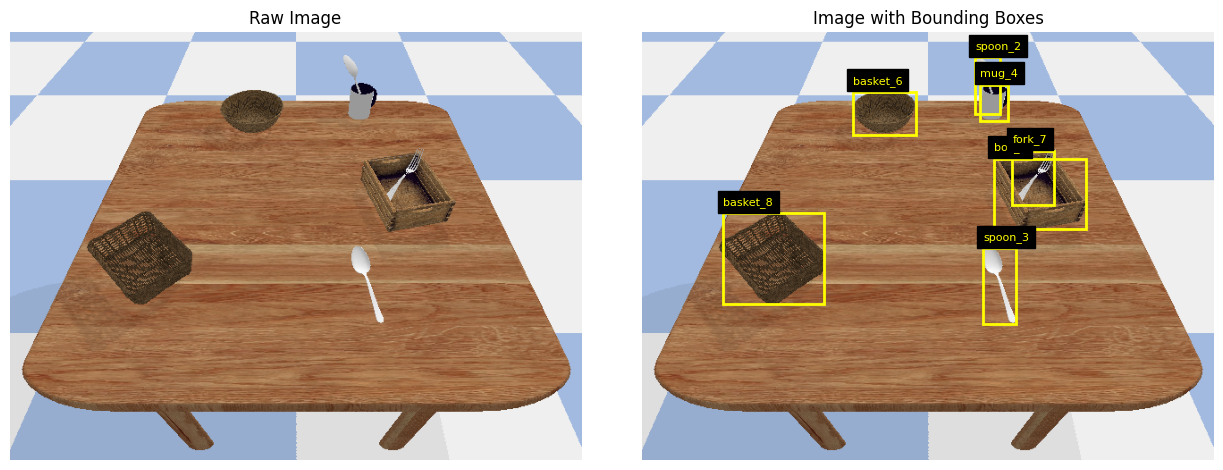

In [8]:
from utils.pybullet_utils import (
    Camera, PyBulletSim, load_object, load_table, get_size
)

def random_pos(x_range, y_range, z_range):
    return [
        random.uniform(*x_range),
        random.uniform(*y_range),
        random.uniform(*z_range)
    ]

def map_position(pos, x_range, y_range, grid_scale=0.01):
    x, y = pos

    # Map x
    new_x_min, new_x_max = x_range
    new_x = x * grid_scale * (new_x_max - new_x_min) + new_x_min

    # Map y
    new_y_min, new_y_max = y_range
    new_y = y * grid_scale * (new_y_max - new_y_min) + new_y_min

    return new_x, new_y

def random_tilt(pos, orn, max_shift=0.05, shift_end=False, tilt_angle=10):
	"""
	Randomly shifts x and y coordinates and tilts the orientation 
	opposite to the shift direction.
	"""
	x0, y0, z0 = pos
	roll0, pitch0, yaw0 = orn

	if shift_end:
		# Pick a random angle and place shift on the circle
		theta = np.random.uniform(0, 2 * np.pi)
		dx = max_shift * np.cos(theta)
		dy = max_shift * np.sin(theta)
	else:
		# Uniform random in the square [-max_shift, +max_shift]
		dx = np.random.uniform(-max_shift, max_shift)
		dy = np.random.uniform(-max_shift, max_shift)

	new_pos = np.array([x0 + dx, y0 + dy, z0])

	# Compute opposite tilt direction
	opposite_dir = np.array([-dx, -dy, 0])
	if np.linalg.norm(opposite_dir) > 1e-6:
		opposite_dir = opposite_dir / np.linalg.norm(opposite_dir)  # normalize

	# Apply tilt proportional to displacement
	tilt_roll = -opposite_dir[1] * np.deg2rad(tilt_angle)  # around x-axis
	tilt_pitch = opposite_dir[0] * np.deg2rad(tilt_angle)  # around y-axis

	# New orientation by adding tilt to initial
	new_orn = np.array([roll0 + tilt_roll, pitch0 + tilt_pitch, yaw0])

	return new_pos, new_orn

def get_available_body_types(objects):
    available = {}
    for obj in objects:
        model_name = obj['model_name']
        if model_name not in available:
            available[model_name] = len(os.listdir(f"objects/{model_name}"))
    return available

def choose_least_used_body_type(model_name, available_body_types, counter):
    count = counter[model_name]
    num_types = available_body_types[model_name]
    min_used = min(count.get(bt, 0) for bt in range(1, num_types + 1))
    candidates = [bt for bt in range(1, num_types + 1) if count.get(bt, 0) == min_used]
    chosen = random.choice(candidates)
    counter[model_name][chosen] += 1
    return chosen

def compute_position_and_orientation(obj, objects, base_z):
	stack_hierarchy = 0
	j = obj['base_id']
	while j is not None:
		stack_hierarchy += 1
		j = objects[j]['base_id']

	pos = [obj['pos'][0], obj['pos'][1], base_z + 0.05 + 0.085 * stack_hierarchy]
	orn = [0, 0, 0]

	if stack_hierarchy > 0 and obj['label'] in [0, 1, 2]:
		orn[0] = np.pi / 2
		j = obj['base_id']
		if objects[j]['label'] in [6, 7]:
			pos, orn = random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
		elif objects[j]['label'] == 8:
			pos, orn = random_tilt(pos, orn, max_shift=0.02, shift_end=True, tilt_angle=10)
		else:
			orn[2] = random.uniform(0, 2 * np.pi)
	else:
		orn[2] = random.uniform(0, 2 * np.pi)

	return pos, orn

def get_objects_from_scene(scene, x_range, y_range):
	objects = []
	for i, obj in enumerate(scene['objects']):
		label = int(obj['label'])
		model_name = OBJECTS[label]['name']
		objects.append({
			'object_id': i,
			'label': label,
			'model_name': model_name,
			'pos': map_position(obj['initial_pos'], x_range, y_range),
			'base_id': obj['initial_base_id'],
		})

	available_body_types = get_available_body_types(objects)
	body_type_counter = defaultdict(Counter)

	for obj in objects:
		model_name = obj['model_name']
		pos, orn = compute_position_and_orientation(obj, objects, z)
		chosen_type = choose_least_used_body_type(model_name, available_body_types, body_type_counter)
		body_id, _ = load_object(model_name, pos, orn, bodyType=chosen_type)

		obj['body_id'] = body_id
		obj['body_type'] = chosen_type

	return objects

# sim = PyBulletSim(p.GUI)
sim = PyBulletSim(p.DIRECT)
table = load_table((100, 100))
_, _, z = get_size(table)
x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]
cam = Camera(target_pos=[0.6, 0, 1.3], distance=0.2, yaw=90, pitch=-50, roll=0)

with open(f"example_scenes/scene_7.json") as f:
	scene = json.load(f)
objects = get_objects_from_scene(scene, x_range, y_range)

sim.step(5)

bboxes, labels = [], []
for obj in objects:
	bboxes.append(cam.compute_bounding_box(obj['model_name'], obj['body_id'], obj['body_type']))
	labels.append(f"{obj['model_name']}_{obj['body_id']}")

cam.draw_bounding_boxes(cam.capture_image(), bboxes, labels)
# cam.show_img(cam.capture_image())

sim.close()

In [ ]:
output_dir = "Scene_Dataset"
scene_files = os.listdir("example_scenes")
scene_files = sorted(scene_files, key=numeric_key)

progress = tqdm(scene_files, desc="Processing scenes")
for scene_path in progress:
	with open(os.path.join("example_scenes", scene_path)) as f:
		scene = json.load(f)

	scene_id = scene['scene_id']
	num_objects = scene['num_objects']
	img_path  = os.path.join(output_dir, f"scene_{scene_id}_n{num_objects}.png")
	json_path = os.path.join(output_dir, f"scene_{scene_id}_n{num_objects}.json")

	if os.path.exists(img_path) and os.path.exists(json_path):
		progress.set_postfix({"status": f"Skipped {scene_id}"})
		continue

	# sim = PyBulletSim(p.GUI)
	sim = PyBulletSim(p.DIRECT)
	table = load_table((100, 100))
	_, _, z = get_size(table)
	x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]
	cam = Camera(target_pos=[0.6, 0, 1.3], distance=0.2, yaw=90, pitch=-50, roll=0)

	objects = get_objects_from_scene(scene, x_range, y_range)
	
	sim.step(5)

	json_data = []
	for obj in objects:
		bbox = cam.compute_bounding_box(obj['model_name'], obj['body_id'], obj['body_type'])
		pos, orn = p.getBasePositionAndOrientation(obj['body_id'])
		euler = p.getEulerFromQuaternion(orn)
		json_data.append({
			"model_name": obj['model_name'],
			"model_id": f"{obj['model_name']}_{obj['body_type']}",
			"obj_id": int(obj['object_id']),
			"6D_pose": [float(x) for x in (pos + euler)],
			"natural_parent_list": [int(obj['base_id'])] if obj['base_id'] is not None else [],
			"bbox": [float(x) for x in bbox],
		})

	image = cam.capture_image()
	img = Image.fromarray(image)
	os.makedirs(output_dir, exist_ok=True)
	img.save(img_path)

	with open(json_path, 'w') as f:
		json.dump(json_data, f, indent=4)

	progress.set_postfix({"status": f"Saved {scene_id}"})
	sim.close()

progress.close()

Processing scenes: 100%|██████████| 1200/1200 [53:04<00:00,  2.65s/it, status=Saved 1199] 
